In [34]:
from taxi import utils, taxi
%load_ext autoreload
%autoreload 2

In [19]:
import gc
import glob
import torch

import numpy as np
from datasets import load_dataset
from graspologic.embed import ClassicalMDS
from scipy.spatial.distance import pdist, squareform
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    PeftModel,
    PeftConfig
)

EMBEDDING_MODEL = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device='cuda:0')

model_id = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True
)
tokenizer.padding_token = tokenizer.eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side='right'


# group 1: Health (2), Sports (5), Family (8)
# group 2: Politics (9), business (6), society and culture (0)
# group 3: Computers (4), Entertainment (7), Education (3) 
coarse_to_fine_dict = {
    0: (2,5,8),
    1: (9,6,0),
    2: (4,7,3)
}

dataset_name = 'community-datasets/yahoo_answers_topics'
topic_key = 'topic'
cache_dir = '~/.cache/huggingface/datasets'

mc_model = 1
mc_variable = 20

N=10000

def get_fine_pis(coarse_pi, coarse_to_fine_dict):
    fine_topics = []
    fine_pi = []
    
    for i, coarse in enumerate(coarse_to_fine_dict):
        for fine in coarse_to_fine_dict[coarse]:
            fine_topics.append(fine)
            fine_pi.append(coarse_pi[coarse] / len(coarse_to_fine_dict[coarse]))
            
    return tuple(fine_topics), tuple(fine_pi)

<All keys matched successfully>


In [20]:
true_pi_list = [(1,0,0), (0,1,0), (0,0,1), (1/3,1/3,1/3)]
datasets = {}

for true_pi in true_pi_list:
    fine_topics, fine_pi = get_fine_pis(true_pi, coarse_to_fine_dict)
    datasets[true_pi] = utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, N, cache_dir=cache_dir, seed=0)

In [21]:
dist_pis = squareform(pdist(true_pi_list))
dist_pis /= np.linalg.norm(dist_pis)
true_geometry = ClassicalMDS(n_components=3).fit_transform(dist_pis)

data_geometry = taxi.get_dataset_geometry(true_geometry, 
                                          datasets, 
                                          EMBEDDING_MODEL
                                         )

In [22]:
query_pi = (1/3, 1/3, 1/3)

n_queries=9
fine_topics, fine_pi = get_fine_pis(query_pi, coarse_to_fine_dict)

query_dataset_dict = {}

for i in range(mc_variable):
    query_dataset = utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, n_queries, cache_dir=cache_dir, seed=i)
    query_dataset_dict[i] = query_dataset

In [23]:
lora_matrices = {}

for save_string in glob.glob('./models/N_10000*lora_128*'):
    print(save_string)

    # Extract true_pi from save_string
    pi_str = save_string.split('pi_')[-1]
    pi_values = [int(x)/100 for x in pi_str.split('_')]
    true_pi = tuple(pi_values)
    print(f"Extracted true_pi: {true_pi}")

    base_model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="cuda:0",
            trust_remote_code=True
    )


    model = PeftModel.from_pretrained(
        base_model,
        save_string,
        torch_dtype=torch.float16,
        device_map='cuda:0'
    )

    loras = taxi.get_lora_matrices(model, target_modules = ["q_proj","k_proj","v_proj"])
    lora_matrices[true_pi] = loras

    #clear memory
    del model
    del base_model
    torch.cuda.empty_cache()
    gc.collect()

structural_geometry = taxi.get_structural_geometry(true_geometry, lora_matrices)

./models/N_10000_lora_128_id_0_pi_000_000_100
Extracted true_pi: (0.0, 0.0, 1.0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./models/N_10000_lora_128_id_0_pi_000_100_000
Extracted true_pi: (0.0, 1.0, 0.0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./models/N_10000_lora_128_id_0_pi_033_033_033
Extracted true_pi: (0.33, 0.33, 0.33)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./models/N_10000_lora_128_id_0_pi_100_000_000
Extracted true_pi: (1.0, 0.0, 0.0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
from collections import defaultdict

generation_kwargs = {'max_new_tokens': 32, 'do_sample': True, 'temperature': 0, 'num_return_sequences': 1}

generation_variable_name = 'temperature'
variable_list = [0, 0.5, 1, 1.5, 1.99]
r_list = [1, 5, 20]

behav = {r: {} for r in r_list}

for save_string in glob.glob('./models/N_10000*lora_128*'):
    print('Model: ' , save_string)

    # Extract true_pi from save_string
    pi_str = save_string.split('pi_')[-1]
    pi_values = [int(x)/100 for x in pi_str.split('_')]
    true_pi = tuple(pi_values)

    base_model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="cuda:0",
            trust_remote_code=True
    )

    model = PeftModel.from_pretrained(
        base_model,
        save_string,
        torch_dtype=torch.float16,
        device_map='cuda:0'
    )

    for variable in variable_list:
        if variable not in behav[r_list[0]]:
            for r in r_list:
                behav[r][variable] = {}
            
        _generation_kwargs = generation_kwargs.copy()    
        _generation_kwargs[generation_variable_name] = variable

        if _generation_kwargs['temperature'] == 0:
            _generation_kwargs['do_sample'] = False
        for mc in range(mc_variable):
            query_strings = [q['question_title'] for q in query_dataset_dict[mc]]
            if mc not in behav[r_list[0]][variable]:
                for r in r_list:                     
                    behav[r][variable][mc] = {}

            if variable != 0:
                _generation_kwargs['num_return_sequences'] = max(r_list)
            else:
                _generation_kwargs['num_return_sequences'] = 1

            print('\tQuerying with: ', query_pi)
            responses = taxi.get_outputs(model, tokenizer, query_strings, _generation_kwargs)

            for r in r_list:
                if _generation_kwargs['temperature'] > 0:
                    behav[r][variable][mc][true_pi] = {'responses': [responses[i*max(r_list): (i+1)*max(r_list)][:r] for i in range(n_queries)]}
                else:
                    behav[r][variable][mc][true_pi] = {'responses': [[responses[i]] for i in range(n_queries)]}

    del model
    del base_model
    torch.cuda.empty_cache()
    gc.collect()

Model:  ./models/N_10000_lora_128_id_0_pi_000_000_100


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)


/home/ubuntu/helivan-project-generation/venvs/helivan/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ubuntu/helivan-project-generation/venvs/helivan/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

In [46]:
behaviorial_geometries_by_query_pi = {}

for r in r_list:
    behaviorial_geometries_by_query_pi[r] = {}
    for variable in variable_list:
        behaviorial_geometries_by_query_pi[r][variable] = {}
        for i in range(mc_variable):
            responses = {k: v['responses'] for k,v in behav[r][variable][i].items()}
            behaviorial_geometries_by_query_pi[r][variable][i] = taxi.get_behavioral_geometry(true_geometry, responses, EMBEDDING_MODEL)

print('done')

done


In [47]:
import pickle 
xs = []
data_ys = []
struct_ys = []
behav_dict = {}

for r in r_list:    
    behav_dict[r] = []        
    for variable in variable_list:
        if r == r_list[0]:
            xs.append(variable)
            data_geo_dist = np.linalg.norm(true_geometry - np.array(data_geometry))
            data_ys.append(data_geo_dist)

            #structural geo dist
            struct_geo_dist = np.linalg.norm(true_geometry - np.array(structural_geometry))
            struct_ys.append(struct_geo_dist)
        
        behav_geo_dist = []
        for mc in range(mc_variable):
            #behaviorial geo dist
            behav_geo_dist.append(np.linalg.norm(true_geometry - np.array(behaviorial_geometries_by_query_pi[r][variable][mc])))

        behav_dict[r].append(np.mean(behav_geo_dist))
            
data_dict = {'x': xs, 'data': data_ys, 'structural': struct_ys, 'behavioral': behav_dict}
pickle.dump(data_dict, open(f'data/effect_of_{generation_variable_name}.p', 'wb'))

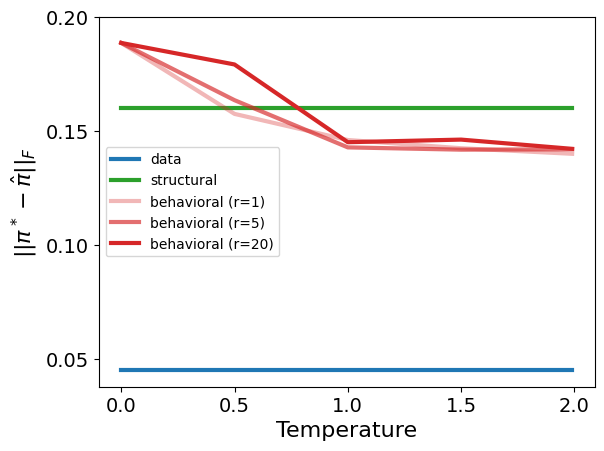

In [48]:
from matplotlib import pyplot as plt
import pickle

generation_variable_name = 'temperature'
data_dict = pickle.load(open(f'data/effect_of_{generation_variable_name}.p', 'rb'))
xs = data_dict['x']

fig, ax = plt.subplots(1,1)

ls_dict = {1: ':', 5: '--', 20: '-'}
alpha_dict = {1: 1/3, 5: 2/3, 20: 1}

# ax.set_xscale('log')
ax.set_ylabel('$||\pi^* - \hat \pi||_F$', fontsize=16)
ax.set_xlabel(r'Temperature', fontsize=16)
ax.plot(xs, data_dict['data'], label='data', lw=3, c='tab:blue')
ax.plot(xs, data_dict['structural'], label='structural', lw=3, c='tab:green')
# plt.plot(xs, func_ys, label='func')
for r, behav_ys in data_dict['behavioral'].items():
    if r not in ls_dict or r not in alpha_dict:
        continue
    ax.plot(xs, behav_ys, lw=3, color='tab:red', alpha=alpha_dict[r], label=f'behavioral (r={r})')

# xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.set_yticks([0.05, 0.1, 0.15, 0.20])
# for n_queries, ls in ls_dict.items():
#     ax.axhline(y=-100, c='k'

# plt.legend(fontsize=12)
ax.tick_params(labelsize=14)
ax.legend()

# plt.savefig('figures/effect_of_changing_q_distribution.pdf')